#**Hard Parameter Sharing Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multi-Task-Learning

/content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multi-Task-Learning


In [ ]:
# raw dataset
!gdown 14EAEMXmd3zs2hIMY63UhHPSFPDAkiTzw

Downloading...
From (original): https://drive.google.com/uc?id=14EAEMXmd3zs2hIMY63UhHPSFPDAkiTzw
From (redirected): https://drive.google.com/uc?id=14EAEMXmd3zs2hIMY63UhHPSFPDAkiTzw&confirm=t&uuid=9369f97b-0dea-4a2b-9e1a-dcf0a85986a2
To: /content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multi-Task-Learning/data/NYUD_MT.tgz
100% 4.22G/4.22G [00:42<00:00, 99.9MB/s]


In [ ]:
!tar -xvzf NYUD_MT.tgz

In [ ]:
#processed dataset
!unzip nyuv2.zip

##**Dataset**

In [ ]:
import os
import torch
import fnmatch
import numpy as np

class NYUv2(torch.utils.data.dataset.Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
        semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))

        return {
            'image': image.float(),
            'semantic': semantic.float(),
            'depth': depth.float()
        }

    def __len__(self):
        return self.data_len

In [ ]:
data_path = './data/NYUDv2'
train_ds = NYUv2(root=data_path, train=True)
val_ds = NYUv2(root=data_path, train=False)

In [ ]:
sample = next(iter(train_ds))

In [ ]:
sample['image'].shape, sample['semantic'].shape, sample['depth'].shape

(torch.Size([3, 288, 384]), torch.Size([288, 384]), torch.Size([1, 288, 384]))

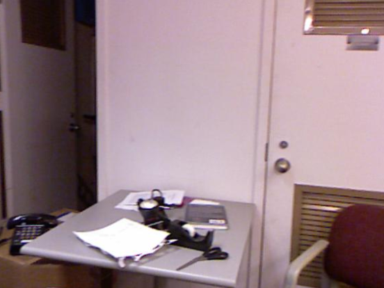

In [ ]:
from PIL import Image
from torchvision import transforms

transform = transforms.ToPILImage()
img = transform(sample['image'])
img

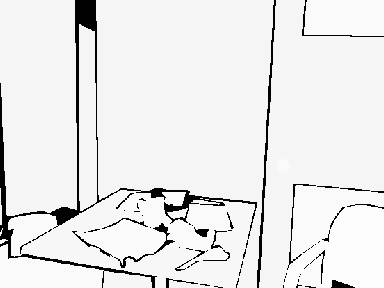

In [ ]:
img = transform(sample['semantic'])
img

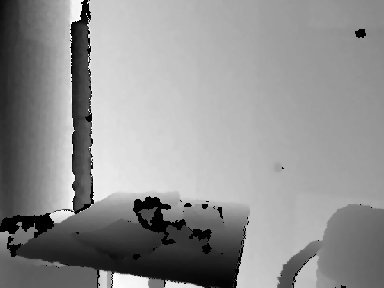

In [ ]:
img = transform(sample['depth'])
img

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

##**Hard Parameter Sharing Model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class SoftParameterSharingModel(nn.Module):
    def __init__(self):
        super(SoftParameterSharingModel, self).__init__()
        # initialise network parameters
        filter = [64, 128, 256, 512, 512]
        self.class_nb = 13

        # define encoder decoder layers
        self.encoder_block = nn.ModuleList([self.conv_layer([3, filter[0], filter[0]], bottle_neck=True)])
        self.decoder_block = nn.ModuleList([self.conv_layer([filter[0], filter[0], self.class_nb], bottle_neck=True)])

        self.encoder_block_t = nn.ModuleList([nn.ModuleList([self.conv_layer([3, filter[0], filter[0]], bottle_neck=True)])])
        self.decoder_block_t = nn.ModuleList([nn.ModuleList([self.conv_layer([2 * filter[0], 2 * filter[0], filter[0]], bottle_neck=True)])])

        for i in range(4):
            if i == 0:
                self.encoder_block.append(self.conv_layer([filter[i], filter[i + 1], filter[i + 1]], bottle_neck=True))
                self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i], filter[i]], bottle_neck=True))
            else:
                self.encoder_block.append(self.conv_layer([filter[i], filter[i + 1], filter[i + 1]], bottle_neck=False))
                self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i], filter[i]], bottle_neck=False))

        for j in range(2):
            if j < 1:
                self.encoder_block_t.append(nn.ModuleList([self.conv_layer([3, filter[0], filter[0]], bottle_neck=True)]))
                self.decoder_block_t.append(nn.ModuleList([self.conv_layer([2 * filter[0], 2 * filter[0], filter[0]], bottle_neck=True)]))
            for i in range(4):
                if i == 0:
                    self.encoder_block_t[j].append(self.conv_layer([2 * filter[i], filter[i + 1], filter[i + 1]], bottle_neck=True))
                    self.decoder_block_t[j].append(self.conv_layer([2 * filter[i + 1], filter[i], filter[i]], bottle_neck=True))
                else:
                    self.encoder_block_t[j].append(self.conv_layer([2 * filter[i], filter[i + 1], filter[i + 1]], bottle_neck=False))
                    self.decoder_block_t[j].append(self.conv_layer([2 * filter[i + 1], filter[i], filter[i]], bottle_neck=False))

        # define pooling and unpooling functions
        self.down_sampling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.up_sampling = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.pred_task1 = self.conv_layer([filter[0], self.class_nb], bottle_neck=True, pred_layer=True)
        self.pred_task2 = self.conv_layer([filter[0], 1], bottle_neck=True, pred_layer=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def conv_layer(self, channel, bottle_neck, pred_layer=False):
        if bottle_neck:
            if not pred_layer:
                conv_block = nn.Sequential(
                    nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
                    nn.BatchNorm2d(channel[1]),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(in_channels=channel[1], out_channels=channel[2], kernel_size=3, padding=1),
                    nn.BatchNorm2d(channel[2]),
                    nn.ReLU(inplace=True),
                )
            else:
                conv_block = nn.Sequential(
                    nn.Conv2d(in_channels=channel[0], out_channels=channel[0], kernel_size=3, padding=1),
                    nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=1, padding=0),
                )

        else:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
                nn.BatchNorm2d(channel[1]),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=channel[1], out_channels=channel[1], kernel_size=3, padding=1),
                nn.BatchNorm2d(channel[1]),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=channel[1], out_channels=channel[2], kernel_size=3, padding=1),
                nn.BatchNorm2d(channel[2]),
                nn.ReLU(inplace=True),
            )

        return conv_block

    def forward(self, x):
        encoder_conv, decoder_conv, encoder_samp, decoder_samp, indices = ([0] * 5 for _ in range(5))
        encoder_conv_t, decoder_conv_t, encoder_samp_t, decoder_samp_t, indices_t = ([0] * 3 for _ in range(5))
        for i in range(3):
            encoder_conv_t[i], decoder_conv_t[i], encoder_samp_t[i], decoder_samp_t[i], indices_t[i] = ([0] * 5 for _ in range(5))

        # global shared encoder-decoder network
        for i in range(5):
            if i == 0:
                encoder_conv[i] = self.encoder_block[i](x)
                encoder_samp[i], indices[i] = self.down_sampling(encoder_conv[i])
            else:
                encoder_conv[i] = self.encoder_block[i](encoder_samp[i - 1])
                encoder_samp[i], indices[i] = self.down_sampling(encoder_conv[i])

        for i in range(5):
            if i == 0:
                decoder_samp[i] = self.up_sampling(encoder_samp[-1], indices[-1])
                decoder_conv[i] = self.decoder_block[-i - 1](decoder_samp[i])
            else:
                decoder_samp[i] = self.up_sampling(decoder_conv[i - 1], indices[-i - 1])
                decoder_conv[i] = self.decoder_block[-i - 1](decoder_samp[i])

        # define task prediction layers
        for j in range(2):
            for i in range(5):
                if i == 0:
                    encoder_conv_t[j][i] = self.encoder_block_t[j][i](x)
                    encoder_samp_t[j][i], indices_t[j][i] = self.down_sampling(encoder_conv_t[j][i])
                else:
                    encoder_conv_t[j][i] = self.encoder_block_t[j][i](torch.cat((encoder_samp_t[j][i - 1], encoder_samp[i - 1]), dim=1))
                    encoder_samp_t[j][i], indices_t[j][i] = self.down_sampling(encoder_conv_t[j][i])

            for i in range(5):
                if i == 0:
                    decoder_samp_t[j][i] = self.up_sampling(encoder_samp_t[j][-1], indices_t[j][-1])
                    decoder_conv_t[j][i] = self.decoder_block_t[j][-i - 1](torch.cat((decoder_samp_t[j][i], decoder_samp[i]), dim=1))
                else:
                    decoder_samp_t[j][i] = self.up_sampling(decoder_conv_t[j][i - 1], indices_t[j][-i - 1])
                    decoder_conv_t[j][i] = self.decoder_block_t[j][-i - 1](torch.cat((decoder_samp_t[j][i], decoder_samp[i]), dim=1))

        t1_pred = F.log_softmax(self.pred_task1(decoder_conv_t[0][-1]), dim=1)
        t2_pred = self.pred_task2(decoder_conv_t[1][-1])

        return {
            'semantic': t1_pred,
            'depth': t2_pred
        }

##**Loss**

In [ ]:
def compute_loss(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss: depth-wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss: l1 norm
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)

    return loss

##**Training**

In [ ]:
from tqdm import tqdm

def train_epoch(train_loader, model, device, optimizer):
    # iteration for all batches
    model.train()
    losses = {'semantic': [], 'depth': [], 'total': []}
    for i, batch in tqdm(enumerate(train_loader)):
        images = batch['image'].to(device)
        semantic = batch['semantic'].long().to(device)
        depth = batch['depth'].to(device)

        output = model(images)

        optimizer.zero_grad()
        train_loss = {
            'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
            'depth': compute_loss(output['depth'], depth, 'depth')
        }

        loss = train_loss['semantic'] + train_loss['depth']

        loss.backward()
        optimizer.step()

        losses['semantic'].append(train_loss['semantic'].item())
        losses['depth'].append(train_loss['depth'].item())
        losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss)/len(task_loss) for task, task_loss in losses.items()}

    return avg_losses


def evaluation_epoch(val_loader, model, device):
    # iteration for all batches
    model.eval()
    losses = {'semantic': [], 'depth': [], 'total':[]}
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_loader)):
            images = batch['image'].to(device)
            semantic = batch['semantic'].long().to(device)
            depth = batch['depth'].to(device)

            output = model(images)

            train_loss = {
                'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
                'depth': compute_loss(output['depth'], depth, 'depth')
            }

            loss = train_loss['semantic'] + train_loss['depth']

            losses['semantic'].append(train_loss['semantic'].item())
            losses['depth'].append(train_loss['depth'].item())
            losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss)/len(task_loss) for task, task_loss in losses.items()}
    return avg_losses

def train(train_loader, val_loader, model, device, optimizer, epochs):
    best_loss = 100.
    for epoch in range(epochs):
        train_loss = train_epoch(train_loader, model, device, optimizer)
        val_loss = train_epoch(train_loader, model, device, optimizer)
        scheduler.step()
        if val_loss['total'] < best_loss:
            best_loss = val_loss['total']
            torch.save(model.state_dict(), './model/soft_parameter_sharing_model_weights.pth')
            print(f"Model save: ./model/soft_parameter_sharing_model_weights.pth")
        print('Epoch: {:04d} | Train: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f} ||'
            'Eval: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f} '
            .format(epoch+1, train_loss['semantic'], train_loss['depth'], train_loss['total'],
                    val_loss['semantic'], val_loss['depth'], val_loss['total']))

    return model

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SoftParameterSharingModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

90800757

In [ ]:
samples = next(iter(train_loader))

In [ ]:
with torch.no_grad():
    output = model(samples['image'].to(device))

In [ ]:
compute_loss(output['semantic'], samples['semantic'].long().to(device), 'semantic')

tensor(2.8844, device='cuda:0')

In [ ]:
compute_loss(output['depth'], samples['depth'].long().to(device), 'depth')

tensor(2.3411, device='cuda:0')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
epochs = 10

train(train_loader, val_loader, model, device, optimizer, epochs)

199it [12:17,  3.71s/it]
199it [04:09,  1.25s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0001 | Train: Semantic Loss 2.0179 - Depth Loss 1.0154 - Total Loss 3.0334 - Semantic IU 0.0735 - Semantic ACC 0.3425 - Depth ABS 1.0154 ||Eval: Semantic Loss 1.7111 - Depth Loss 0.8988 - Total Loss 2.6099 - Semantic IU 0.0995 - Semantic ACC 0.4160 - Depth ABS 0.8988 


199it [04:12,  1.27s/it]
199it [04:15,  1.29s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0002 | Train: Semantic Loss 1.6476 - Depth Loss 0.8688 - Total Loss 2.5164 - Semantic IU 0.1116 - Semantic ACC 0.4347 - Depth ABS 0.8688 ||Eval: Semantic Loss 1.6044 - Depth Loss 0.8488 - Total Loss 2.4533 - Semantic IU 0.1191 - Semantic ACC 0.4464 - Depth ABS 0.8488 


199it [04:15,  1.29s/it]
199it [04:15,  1.28s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0003 | Train: Semantic Loss 1.5815 - Depth Loss 0.8322 - Total Loss 2.4137 - Semantic IU 0.1272 - Semantic ACC 0.4556 - Depth ABS 0.8322 ||Eval: Semantic Loss 1.5480 - Depth Loss 0.8158 - Total Loss 2.3638 - Semantic IU 0.1365 - Semantic ACC 0.4676 - Depth ABS 0.8158 


199it [04:15,  1.29s/it]
199it [04:12,  1.27s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0004 | Train: Semantic Loss 1.5123 - Depth Loss 0.8011 - Total Loss 2.3134 - Semantic IU 0.1478 - Semantic ACC 0.4795 - Depth ABS 0.8011 ||Eval: Semantic Loss 1.5031 - Depth Loss 0.7894 - Total Loss 2.2925 - Semantic IU 0.1487 - Semantic ACC 0.4826 - Depth ABS 0.7894 


199it [04:11,  1.26s/it]
199it [04:11,  1.26s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0005 | Train: Semantic Loss 1.4719 - Depth Loss 0.7731 - Total Loss 2.2449 - Semantic IU 0.1574 - Semantic ACC 0.4915 - Depth ABS 0.7731 ||Eval: Semantic Loss 1.4431 - Depth Loss 0.7563 - Total Loss 2.1994 - Semantic IU 0.1677 - Semantic ACC 0.5025 - Depth ABS 0.7563 


199it [04:11,  1.26s/it]
199it [04:11,  1.26s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0006 | Train: Semantic Loss 1.4070 - Depth Loss 0.7376 - Total Loss 2.1446 - Semantic IU 0.1798 - Semantic ACC 0.5110 - Depth ABS 0.7376 ||Eval: Semantic Loss 1.3800 - Depth Loss 0.7026 - Total Loss 2.0826 - Semantic IU 0.1973 - Semantic ACC 0.5250 - Depth ABS 0.7026 


199it [04:11,  1.26s/it]
199it [04:11,  1.26s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0007 | Train: Semantic Loss 1.3528 - Depth Loss 0.7029 - Total Loss 2.0557 - Semantic IU 0.2068 - Semantic ACC 0.5318 - Depth ABS 0.7029 ||Eval: Semantic Loss 1.3245 - Depth Loss 0.6983 - Total Loss 2.0228 - Semantic IU 0.2226 - Semantic ACC 0.5429 - Depth ABS 0.6983 


199it [04:11,  1.26s/it]
199it [04:11,  1.26s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0008 | Train: Semantic Loss 1.2773 - Depth Loss 0.6686 - Total Loss 1.9459 - Semantic IU 0.2384 - Semantic ACC 0.5564 - Depth ABS 0.6686 ||Eval: Semantic Loss 1.2430 - Depth Loss 0.6443 - Total Loss 1.8873 - Semantic IU 0.2554 - Semantic ACC 0.5702 - Depth ABS 0.6443 


199it [04:12,  1.27s/it]
199it [04:14,  1.28s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0009 | Train: Semantic Loss 1.2114 - Depth Loss 0.6342 - Total Loss 1.8456 - Semantic IU 0.2733 - Semantic ACC 0.5833 - Depth ABS 0.6342 ||Eval: Semantic Loss 1.1725 - Depth Loss 0.6177 - Total Loss 1.7903 - Semantic IU 0.2921 - Semantic ACC 0.5953 - Depth ABS 0.6177 


199it [04:16,  1.29s/it]
199it [04:15,  1.29s/it]


Model save: ./model/soft_parameter_sharing_model_weights.pth
Epoch: 0010 | Train: Semantic Loss 1.1197 - Depth Loss 0.5938 - Total Loss 1.7135 - Semantic IU 0.3081 - Semantic ACC 0.6144 - Depth ABS 0.5938 ||Eval: Semantic Loss 1.0921 - Depth Loss 0.5970 - Total Loss 1.6891 - Semantic IU 0.3274 - Semantic ACC 0.6257 - Depth ABS 0.5970 


##**Inference**

In [ ]:
model_path = './model/soft_parameter_sharing_model_weights.pth'
model = SoftParameterSharingModel()
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

In [ ]:
test_sample = next(iter(val_ds))
test_sample = {task: test_sample[task].unsqueeze(0).to(device) for task in test_sample.keys()}

In [ ]:
test_sample['image'].shape

torch.Size([1, 3, 288, 384])

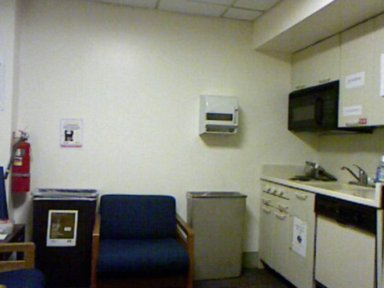

In [ ]:
img = transform(test_sample['image'][0])
img

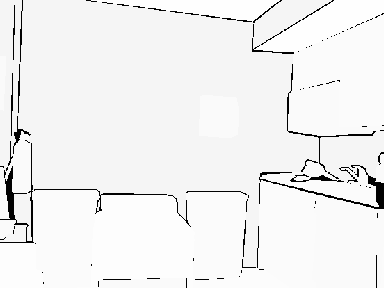

In [ ]:
img = transform(test_sample['semantic'][0])
img

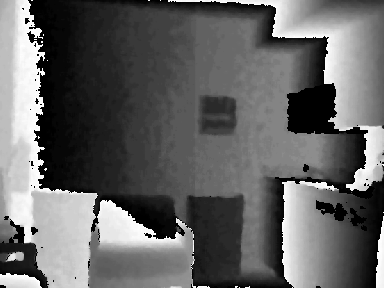

In [ ]:
img = transform(test_sample['depth'][0])
img

In [ ]:
with torch.no_grad():
    output = model(test_sample['image'])

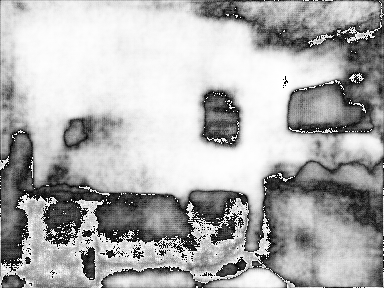

In [ ]:
img = transform(torch.max(output['semantic'][0], dim=0).values)
img